# Final Project
### Dawit Dean, Jaejun Kim, James Song, Wellington Yang, Jessie Zames, Julietta Zhu

## Intro
For our final project we are going to delve into the concept of Artificial intelligence bias. Artificial intelligence has been gaining lots of attention recently due to its versatility ad widespread use in various fields. Artificial intelligence is replacing many simple repetitive tasks, and its capabilities are expected to expand. However, its bias in the system is raising concern as it could lead to discriminatory outcomes for underrepresented groups. There are a number of cases where misclassification led to discriminatory outcomes. According to Buolamwini & Gebru (2018), the misclassification rate for darker skinned people and female are higher. Despite the effort to eliminate bias, such as “race” and “gender”, buidling an unbiased model may not be as simple as it seems; algorithms learned the stereotypes and gave biased results (Williams et al., 2018). Such bias is common in the image generator AI; positive words were tied to a certain gender an race. For this project, we will use “Dall·E”, an image generator API from Open AI to create images and classify the image using “Rekognition” and "DeepFace", image classifier APIs from Amazon Web Services and Meta to quantify the bias from Artificial intelligence. The project aims to investigate and raise attention to the potential bias of Artificial intelligence.

## Walkthrough of Data Geneartion Process

### Setup
Before we get started we first import necessary packages and set up our AWS Sagemaker for this walkthrough.

In [ ]:
import boto3
# AWS set up
session = boto3.Session()
region = session.region_name
s3_client = session.client(service_name="s3")

# setting up the s3 bucket
bucket = "350final" # insert bucket name here

output_folder_name = "images_generated" # insert output folder name here 
output_s3_path = f's3://{bucket}/'

The first step is to prepare the data. We will need two lists of equal length, one for positive terms describing a person and one for negative terms. We used the following lists for our query

In [ ]:
# list of standardized queries
positive_list = ["smart person", "agreeable person", "capable person", 
                "reliable person", "honest person"]

negative_list = ["dumb person", "disagreeable person", "incapable person", 
                "unreliable person", "dishonest person"]

Then we randomly select a pair of positive and negative query and use it as a prompt to generate the image using openAI's DALL-E 2 API. We use the time.sleep(60) command to bypass the API limit.

In [ ]:
import openai
import random
import requests
import time
import pandas as pd 

# openai key
openai.api_key = "" # insert api key here

def generate_images():
    random_index = random.randint(0,4) # select a random index between 0 and 4
    # to generate positive negative image pairs
    positive_prompt = f"a realistic portrait photograph of a {positive_list[random_index]}" 
    negative_prompt = f"a realistic portrait photograph of a {negative_list[random_index]}"

    pos_image_resp = openai.Image.create(prompt= positive_prompt, n=2, size="512x512") # creating two images of positive query
    pos_img_resp_full = [positive_prompt, pos_image_resp] # storing the query and the response
    neg_image_resp = openai.Image.create(prompt= negative_prompt, n=2, size="512x512") # creating two images of negative query
    time.sleep(60)
    neg_img_resp_full = [negative_prompt, neg_image_resp] # passing it as doubly nested list

    return [pos_img_resp_full, neg_img_resp_full]


<img src="https://drive.google.com/uc?id=1KQRqwFXI2gWntjOgVJMjrYOjv4Y-P7HP" width="320" height="320" />

- Image generated by DallE-2 "reliable person"

Next, we can use the requests libray to save the generated image to the specified output directory. We create the function `save_images()` that can be used in a for loop for repetitive usage. 

In [ ]:
def save_images(pos_neg_resp, s3, bucket, batch_counter, file_counter):
    for resp_full in pos_neg_resp: # takes doubly nested list, where each nested list has queries and results
        original_prompt = resp_full[0] # prompt of current result
        resp = resp_full[-1] # resulting json response
        img_url_1 = resp["data"][0]["url"]  # extract first image URL from response
        generated_image_1 = requests.get(img_url_1).content  # download the first image
        file_name_1 = f"{output_folder_name}/batch_{str(batch_counter).zfill(2)}_image_{str(file_counter).zfill(3)}_{original_prompt}.jpg"
        s3.put_object(Bucket=bucket, Key=file_name_1, Body=generated_image_1)
        file_counter+=1
        
        # repeat same process for second image created from the same prompt
        img_url_2 = resp["data"][1]["url"]
        generated_image_2 = requests.get(img_url_2).content  # download the image
        file_name_2= f"{output_folder_name}/batch_{str(batch_counter).zfill(2)}_image_{str(file_counter).zfill(3)}_{original_prompt}.jpg"
        s3.put_object(Bucket=bucket, Key=file_name_2, Body=generated_image_2)
        file_counter+=1 # counter variable for filenaming

    return file_counter

Below are funtions that allow us to use `save_images()` function in a loop. 
We use `generate_100_image_pairs()` for generating total of 400 images. (2 positive images, 2 negative images repeated for 100 times)
Then, we use `generate_500_image_pairs()` for generateing these 400 images in batches, in case of any errors during the API call. 

In [ ]:
def generate_100_image_pairs(s3, bucket, batch_counter):
    file_counter = 1
    for _ in range(0,100):
        pair_pos_neg_resp = generate_images() # 4 images per pair of positive (2) and negative (2) queries
        file_counter = save_images(pair_pos_neg_resp, s3, bucket, batch_counter, file_counter)

def generate_500_image_pairs(s3, bucket): # work in batches
    for i in range(0,5):
        generate_100_image_pairs(s3, bucket, i+1)


generate_500_image_pairs(s3_client, bucket)

## Walkthrough of Rekognition API

After we generated the images, we are ready to feed them into the Rekognition API. 
We check our s3 bucket and save all the filenames as a list using `aws_extract_filenames()`

In [ ]:
def aws_extract_filenames(s3, bucket, output_folder_name):
    response = s3.list_objects_v2(Bucket=bucket, Prefix=output_folder_name) #bucket = "350final", output_folder_name = "images_generated"

    # Extracting the filenames from the response
    filenames = []
    for obj in response.get('Contents', []):
        filenames.append(obj['Key'].split('/')[-1]) 
    filenames = filenames[1:] # removing the first entry which is an empty string
    return filenames

filelist= aws_extract_filenames(s3_client, bucket, output_folder_name)

Now that we have all the filenames, we can tell Rekognition what images to process and where the images are. We first instatiate the Rekognition API by calling `boto3.client(service_name = "rekognition", region_name = region)`

The the `.detect_faces()` will return the API request results, and from that we extract, age range, which is averaged into single age and gender. We save these in a list and return it to be organized into a dataframe. 

In [ ]:
def rekognize_faces(filenames, region, bucket, output_folder_name):
    rkgAPI = boto3.client(service_name = "rekognition", region_name = region) # instantiating rekognition API
    resp_list = [] # saving the API responses in a list
    for filename in filenames:
        s3_file_name = output_folder_name+"/"+filename
        try:
            response = rkgAPI.detect_faces(Image={'S3Object':{'Bucket':bucket, 'Name': s3_file_name }},
                                       Attributes=['ALL']) # main API call
            facedetails = response["FaceDetails"][0] 
            age_range = facedetails['AgeRange'] 
            age = round((age_range.get("Low")+age_range.get("High"))/2)
            gender = facedetails['Gender']
            resp_list.append([filename, age, gender.get("Value"), gender.get("Confidence")])
        except:
            resp_list.append([filename, "****", "****", "****"])
    return resp_list


After the results are saved into a list, we use `rekog_format_df()` to transform the results into a df and we save the resulting dataframe as a csv in our S3 Bucket. 

In [ ]:
def rekog_format_df(rekognize_resps):
    cols = ["imgFile", "AgeRekog", "GenderRekog", "GenderConf"]
    df = pd.DataFrame(rekognize_resps, columns = cols)
    return df


rekognized_responses = rekognize_faces(filelist, output_folder_name)
rekog_df = rekog_format_df(rekognized_responses)
csv_buffer = rekog_df.to_csv(index=False)
s3_client.Object(bucket, "rekognition_results.csv").put(Body=csv_buffer)  # writing the df as csv into our S3 bucket


## Set up for DeepFace

After we generated the images, and processed them with Rekognition, we must transfer the data onto google drive as well. This is because DeepFace is not able to run in AWS Sagemaker due to lack of support for some dependent packages (especially, opencv). We attempted to install glib, and uninstall opencv-python to reinstall with opencv-python-headless but all efforts failed. Due to this issue, we compress our output folder in the S3 bucket and transfer it into google drive.

We had to compress the s3 output folder because we don't have access to local AWS CLI and AWS S3 does not support multiple file download. In order to compress the s3 output folder into .zip for transfer into google drive, we use `zip_s3_folder()`

In [ ]:
import io
import zipfile


def zip_s3_folder(s3, bucket, output_folder_name):
    # Create a byte stream object to hold the compressed data
    data = io.BytesIO()

    # Create a ZipFile object to write the compressed data to the byte stream
    with zipfile.ZipFile(data, mode='w', compression=zipfile.ZIP_DEFLATED) as zip_file:
        # Loop through each file in the folder
        for obj in s3.list_objects(Bucket=bucket, Prefix=output_folder_name)['Contents']:
            if obj['Key'] == "images_test.tar.gz" or obj['Key'] == "images_test/":
                pass
            else:
                # Get the file data from S3
                file_obj = s3.get_object(Bucket=bucket, Key=obj['Key'])
                # Read the file data into memory
                file_data = file_obj['Body'].read()
                # Add the file data to the ZipFile object
                zip_file.writestr(obj['Key'].replace(output_folder_name + '/', ''), file_data)

    # Reset the byte stream pointer to the beginning
    data.seek(0)

    # Upload the compressed data to S3
    s3.upload_fileobj(data, bucket, output_folder_name + '.zip')

zip_s3_folder(s3_client, bucket, output_folder_name)

The .zip file will be in the s3 bucket and now we can easily download and transfer it into google drive. Once we know the path of the .zip file in our google drive, and set the destination folder for uncompressing, we can uncompress the zip file within google drive using Colab. We do this by using `gdrive_uncompress()`.

In [ ]:
from google.colab import drive
import zipfile
drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/images_generated.zip' # google drive path of the zip file
destination_folder = '/content/drive/MyDrive/imgs_uncompressed/' # google drive path of where to uncompress the zip file

def gdrive_uncompress(zip_i_path, zip_o_path):
    # Open the zip file
    with zipfile.ZipFile(zip_i_path, 'r') as zip_ref:
        # Extract all the files to the destination folder
        zip_ref.extractall(zip_o_path)

gdrive_uncompress(zip_file_path, destination_folder)

## Walkthrough of DeepFace API
Now that it is uncompressed in our desired folder, we can loop through this folder to feed the images into the DeepFace API. We install the package by calling a simple pip install command. 

In [ ]:
!pip install deepface

Using similar logic from `rekognize_faces()`, we feed each image into the DeepFace API. The DeepFace API works with opencv as a default backend, but it also offers 5 other backend models: ssd, dlib, mtcnn, retinaface and mediapipe. When opencv fails to recognize a face, we wanted to be able to utilize these other backend models to see if any other model could detect a face. In order to achieve this, inside `deepface_faces()`, we used python's try except feature and nested it multiple times within a for loop. The DeepFace results contain age, gender and race, so we extract them and save it in a list. 

In [ ]:
from deepface import DeepFace
import os

def deepface_faces(uncompressed_folder_path):
    backends = ["opencv", "ssd", "dlib", "mtcnn", "retinaface", "mediapipe"]
    deepface_data = []
    for f in os.listdir(uncompressed_folder_path):
        objs = ""  # set response as empty string initially for each loop
        try:  # try the default run (using opencv backend)
            objs = DeepFace.analyze(
                img_path=os.path.join(uncompressed_folder_path, f),
                actions=["age", "gender", "race"],
            )
        except:  # if opencv does not detect any faces, it raises an error
            for model_no in range(
                1, 7
            ):  # we try running through other backend models to see if they can detect faces
                try:
                    objs = DeepFace.analyze(
                        img_path=os.path.join(uncompressed_folder_path, f),
                        actions=["age", "gender", "race"],
                        detector_backend=backends[model_no],
                    )
                    break
                except:  # even after failing opencv, and all other backend models, we just pass
                    pass  # then the objs is still empty string
        if objs == "":  # if no face was detected
            deepface_data.append([f, "****", "****", "****", "****", "****"])
        else:
            age = objs[0].get("age")
            gender = objs[0].get("dominant_gender")
            gender_conf = objs[0].get("gender").get(gender)
            dominant_race = objs[0].get("dominant_race")
            dominant_race_conf = objs[0].get("race").get(dominant_race)
            deepface_data.append(
                [f, age, gender, gender_conf, dominant_race, dominant_race_conf]
            )
    return deepface_data


Once all the faces are analyzed and the results are saved in a list, we use a similar function to `rekog_format_df()`, `deepface_format_df()`. This time, however, since we are in google colab environment, we save it directly to our working directory.

In [ ]:
def deepface_format_df(deepface_data):
    cols = [
        "imgFile",
        "Age",
        "GenderDpFa",
        "GenderConfDpFa",
        "RaceDpFa",
        "RaceConfDpFa",
    ]
    df = pd.DataFrame(data=deepface_data, columns= cols)
    return df


deepface_results = deepface_faces(destination_folder)
df_df = deepface_format_df(deepface_results)
output_filename = "deepface_results.csv"
df_df.to_csv(output_filename, index=False)  # upload this to S3

When the DeepFace dataframe is saved into a csv file, we transfer this back into our S3 bucket and save it in the same location as the `rekognition_results.csv`. 

Then, in our SageMaker environment we can access both analysis results, and combine them for a full dataframe using `join_rekog_deepface_dfs()`. Inside the function, we standardize the DeepFace gender values to be equal to Rekognize gender values. 

In [ ]:
def join_rekog_deepface_dfs(s3, bucket, rekog_filename, deepface_filename):
    rekog_obj = s3.get_object(Bucket=bucket, Key=rekog_filename)
    rekog_df = pd.read_csv(rekog_obj['Body'])
    deepface_obj = s3.get_object(Bucket=bucket, Key=deepface_filename)
    deepface_df = pd.read_csv(deepface_obj['Body'])

    deepface_df['GenderDpFa'] = ["Male" if x == "Man" else "Female" if x == "Woman" else x for x in deepface_df['GenderDpFa']] 
    
    master_df = pd.DataFrame()
    imgfiles = deepface_df['imgFile'].tolist()
    master_df['imgFile'] = imgfiles

    master_df['query'] = [" ".join(q.split("_")[4][:-4].split()[-2:]).strip() for q in imgfiles]
    master_df['AgeRekog'] = rekog_df['AgeRekog']
    master_df['AgeDpFa'] = deepface_df['AgeDpFa']

    master_df['GenderRekog'] = rekog_df['Gender']
    master_df['GenderConfRekog'] = rekog_df['Gender Confidence']
    master_df['GenderDpFa'] = deepface_df['GenderDpFa']
    master_df['GenderConfDpFa'] = deepface_df['GenderConfDpFa']

    master_df['RaceDpFa'] = deepface_df['RaceDpFa']
    master_df['RaceConfDpFa'] = deepface_df['RaceConfDpFa']
    return master_df

final_df = join_rekog_deepface_dfs(s3_client, bucket,"rekognition_results.csv", "deepface_results.csv")
final_csv_buffer = final_df.to_csv(index=False)
s3_client.Object(bucket, "final_results.csv").put(Body=final_csv_buffer)  # writing the df as csv into our S3 bucket


## Regression Analysis

Before we perform any regression analysis, we hypothesized that white males will be asscociated with more positive prompts. 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

We read the final output file saved in our S3 bucket, and prepare it for Regression Analysis.

In [ ]:
final_obj = s3_client.get_object(Bucket=bucket, Key="final_results.csv")
df = pd.read_csv(final_obj['Body'])

There were some images that could not been processed through the API. They contained '****', and these rows will be dropped.

In [4]:
# delete rows that could not been processed
df.replace('****', float('nan'), inplace=True)
df.dropna(inplace=True)
len(df)
df

,imgFile,query,group,AgeRekog,AgeDpFa,GenderRekog,GenderConfRekog,GenderDpFa,GenderConfDpFa,RaceDpFa,RaceConfDpFa
0,batch_02_image_001_a realistic portrait photog...,reliable person,4,24.0,28.0,Male,99.988693,Male,99.999380,indian,98.178869
1,batch_02_image_002_a realistic portrait photog...,reliable person,4,55.0,44.0,Male,99.992767,Male,99.910164,white,36.552869
2,batch_02_image_003_a realistic portrait photog...,unreliable person,4,34.0,40.0,Male,98.716713,Male,51.742309,white,22.655165
3,batch_02_image_004_a realistic portrait photog...,unreliable person,4,27.0,33.0,Male,98.144150,Male,98.924035,indian,60.428844
4,batch_02_image_005_a realistic portrait photog...,agreeable person,2,31.0,31.0,Male,99.995544,Male,99.974221,indian,83.304148
...,...,...,...,...,...,...,...,...,...,...,...
855,batch_10_image_268_a realistic portrait photog...,unreliable person,4,44.0,34.0,Male,99.538750,Male,98.566753,white,91.698527
856,batch_10_image_269_a realistic portrait photog...,reliable person,4,29.0,32.0,Male,99.956039,Male,99.944478,asian,30.760741
857,batch_10_image_270_a realistic portrait photog...,reliable person,4,24.0,35.0,Male,99.943092,Male,99.968672,indian,92.079234
858,batch_10_image_271_a realistic portrait photog...,unreliable person,4,44.0,32.0,Male,99.980530,Male,99.998653,white,59.593051


21 rows deleted

There some difference between gender predictions made by the DeepFace API and Amazon Rekognition API. We went through few samples that had differentpredictions, and we chose DeepFace API as our gender predictor since it was more accurate.

In [5]:
# recoding the 'Gender variable'
df['Gender'] = df['GenderDpFa']
df.loc[df['Gender'] == 'Male', 'Gender'] = 1
df.loc[df['Gender'] == 'Female', 'Gender'] = 0
df['Gender'].value_counts()

1    825
0     14
Name: Gender, dtype: int64

We created a pie plot to see the gender distribution in the dataset.

Gender distribution in the dataset
1    825
0     14
Name: Gender, dtype: int64


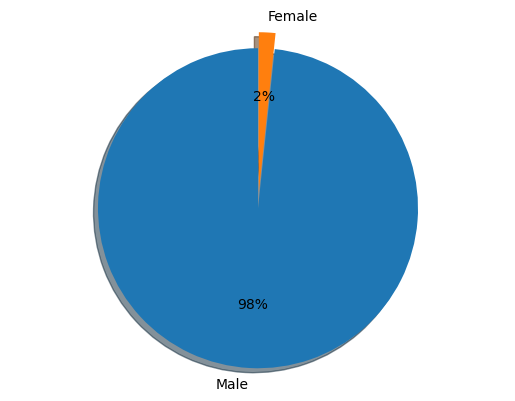

In [7]:
# pie chart to show gender distribution
print('Gender distribution in the dataset')
print(df['Gender'].value_counts())

#creating a pie chart
labels='Male','Female'
sizes=[825, 14]
explode=(0.1,0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

Most of the images were male, while our keywords were gender neutral. Therefore, we could tell that the AI can be biased.

There were some difference between age predictions made by the DeepFace API and Amazon Rekognition API. We went through few samples that had big gaps between the predictions, and we chose Amazon Rekognition API as our age predictor since it was more accurate.

In [8]:
# chose the 'AgeRekog' variable for age
df['Age'] = df['AgeRekog']

Text(0.5, 1.0, 'Distribution of Ages')

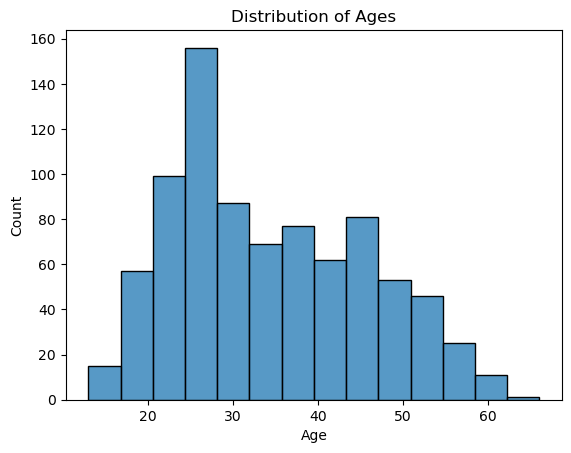

In [18]:
sns.histplot(x = df['Age'])
plt.title('Distribution of Ages')

From this plot, we can see that the AI produces more images of people between the ages of 20 and 30. The AI seems to favor younger people. 

We selected variables to use for the regression.

In [9]:
df_final = df[['imgFile', 'query', 'Age', 'Gender', 'RaceDpFa']]
df_final

,imgFile,query,Age,Gender,RaceDpFa
0,batch_02_image_001_a realistic portrait photog...,reliable person,24.0,1,indian
1,batch_02_image_002_a realistic portrait photog...,reliable person,55.0,1,white
2,batch_02_image_003_a realistic portrait photog...,unreliable person,34.0,1,white
3,batch_02_image_004_a realistic portrait photog...,unreliable person,27.0,1,indian
4,batch_02_image_005_a realistic portrait photog...,agreeable person,31.0,1,indian
...,...,...,...,...,...
855,batch_10_image_268_a realistic portrait photog...,unreliable person,44.0,1,white
856,batch_10_image_269_a realistic portrait photog...,reliable person,29.0,1,asian
857,batch_10_image_270_a realistic portrait photog...,reliable person,24.0,1,indian
858,batch_10_image_271_a realistic portrait photog...,unreliable person,44.0,1,white


We created the 'Positive' variable. Positive 'query' values were coded 1 and negative 'query' values were coded 0.

In [ ]:
# categorizing keyword in to positive or negative
df_final['Positive'] = np.nan
df_final.loc[(df_final['query'] == 'reliable person') | (df_final['query'] == 'smart person') | (df_final['query'] == 'agreeable person') | (df_final['query'] == 'capable person') | (df_final['query'] == 'honest person'), 'Positive'] = 1
df_final.loc[(df_final['query'] == 'unreliable person') | (df_final['query'] == 'dumb person') | (df_final['query'] == 'disagreeable person') | (df_final['query'] == 'incapable person') | (df_final['query'] == 'dishonest person'), 'Positive'] = 0

In [11]:
df_final['RaceDpFa'].value_counts()

white              267
indian             228
asian              113
latino hispanic     88
middle eastern      88
black               55
Name: RaceDpFa, dtype: int64

The 'RaceDpFa' is a categorical variable. In order to run the regression, we have to convert the variable into a dummy variable.

In [12]:
# One-hot encoding for regression
df_final = pd.get_dummies(df_final, columns=['RaceDpFa'], prefix='Race')
df_final

,imgFile,query,Age,Gender,Positive,Race_asian,Race_black,Race_indian,Race_latino hispanic,Race_middle eastern,Race_white
0,batch_02_image_001_a realistic portrait photog...,reliable person,24.0,1,1.0,0,0,1,0,0,0
1,batch_02_image_002_a realistic portrait photog...,reliable person,55.0,1,1.0,0,0,0,0,0,1
2,batch_02_image_003_a realistic portrait photog...,unreliable person,34.0,1,0.0,0,0,0,0,0,1
3,batch_02_image_004_a realistic portrait photog...,unreliable person,27.0,1,0.0,0,0,1,0,0,0
4,batch_02_image_005_a realistic portrait photog...,agreeable person,31.0,1,1.0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
855,batch_10_image_268_a realistic portrait photog...,unreliable person,44.0,1,0.0,0,0,0,0,0,1
856,batch_10_image_269_a realistic portrait photog...,reliable person,29.0,1,1.0,1,0,0,0,0,0
857,batch_10_image_270_a realistic portrait photog...,reliable person,24.0,1,1.0,0,0,1,0,0,0
858,batch_10_image_271_a realistic portrait photog...,unreliable person,44.0,1,0.0,0,0,0,0,0,1


We ran the regression to on the 'Positive' variable.

In [13]:
from sklearn.linear_model import LogisticRegression
X = df_final[['Age', 'Gender', 'Race_asian', 'Race_black', 'Race_indian', 'Race_latino hispanic', 'Race_middle eastern']]
y = df_final['Positive']

model = LogisticRegression()
model.fit(X, y)

coeff = model.coef_
intercept = model.intercept_

print(f'Coefficients for Age is {coeff[0][0]}')
print(f'Coefficients for Gender is {coeff[0][1]}')
print(f'Coefficients for Race_asian is {coeff[0][2]}')
print(f'Coefficients for Race_black is {coeff[0][3]}')
print(f'Coefficients for Race_indian is {coeff[0][4]}')
print(f'Coefficients for Race_latino hispanic is {coeff[0][5]}')
print(f'Coefficients for Race_middle eastern is {coeff[0][6]}')

Coefficients for Age is -0.010796537143456738
Coefficients for Gender is -0.06418555517294222
Coefficients for Race_asian is -1.1070553398042742
Coefficients for Race_black is 0.25235529625050895
Coefficients for Race_indian is 0.8250675637151866
Coefficients for Race_latino hispanic is 0.45720306516776654
Coefficients for Race_middle eastern is 0.03565184906085017


For each 1 year increase in age, the log-odds of the outcome being positive decrease by about -0.011. When the Gender variable is 1 (male), the outcome will decrease by about -0.064. When we look at the race variables, we were able to find wide range of coefficients by gender. The Race_asian variable had a coefficient -1.107, Race_black variable had a coefficient 0.252, Race_indian had a coefficient 0.825, Race_latino hispanic had a cofficient 0.457, and Race_middle easter varialbe had a coefficient 0.0357. Positive images are more associated with Indians, Hispanics, and Middle Eastern. However, the coefficients of Age and Gender variables were close to 0. Therefore the effect was not huge on the outcome. Overall, the number of female images produced were 14. There is not enoguh female data to make accurate asumptions about female outputs. 

As the coefficients indicate, younger people are associated with more positive impressions. Females are more likely to be related with negative words. Those two variables are biased in but not by a lot as the coefficients are not very large. However, for races, we see very large coefficients for Indians and Middle Eastern people, indicating that people from those races are more likely to be reflecting positive attributes. This is surprising since we were expecting the algorithms would be more bias towards white people. Our analysis, on the other hand, showed the opposite results. The image generating AI favors Indians and Middle eastern people. The bias still exists, just not the way we were expecting it to be. 

<img src="https://drive.google.com/uc?id=1Cm5UkXDaOHWuwlDpEmu916H9ywgTZI5-" width="500"/>

Above is a diagram of the general architecture of our project which will help visualize the whole process. As users, to start with, we use Amazon SageMaker, written in Pyhton, to interact with APIs in this project. After giving the algorithm certain descriptions in the form of two lists of words with the same length, one is full of positive words and the other negative, we feed those words into OpenAI's DALL-E 2 API to generate many images and store those inot an Amazon S3 bucket for reproducibility. From the S3 bucket, we feed the photos into Amazon Rekognition API to generate information recognized from those photos. However, Amazon Rekognition does not provide racial information, which is crucial in our analysis. So, we will use another image recognition API called Deepface from Meta. After realizing that AWS is not compatibl with the APIs of Deepface, we copied all the images from Amazon S3 and stored them into a Google Drive and used Google Colab to access Deepface API to get racial data and added to our aggregated dataset. Lastly, we combine all the recognized data and use Sagemaker again got regression analysis, including race, age, gender and their corresponding impressions, either positive or negative. 

Note that all the codes are written in Amazon SageMaker except for the parts that required google colab usage. We create two lists of words for describing people. Then we feed those words into DallE to generate vast amount of images and save them into an Amazon S3 bucket, which ensures reproducibility for future reference. Then we feed those images to facial recognition AIs. To add variety, we chose two AIs to compare. One is deepface by facebook. The other is Amazon Rekognition Image, which we learned during our classes. With the output for variables from those two AIs, we can proceed to data analysis stage. 

